In [1]:
import os
import json
import random
import cv2
import numpy as np
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models
from torchvision.ops import nms, RoIPool

In [2]:
from mask_rcnn_utils.display import plot_boxes, plot_img_seg, plot_image, plot_boxes_instance_masks
from mask_rcnn_utils.box_functions import jaccard, loc2bbox, bbox2loc
from mask_rcnn_utils.generate_anchor_boxes import generator_anchors
from mask_rcnn_utils.utils import normal_init
from mask_rcnn_utils.create_labels_funcs import create_anchor_labels, create_box_target_labels

In [3]:
PATH = "data/VOCdevkit/VOC2012"

In [4]:
class PascalDataset(Dataset):
    def __init__(self, data, img_size):
        self.image_path = "data/VOCdevkit/VOC2012/JPEGImages"
        self.seg_path = "data/VOCdevkit/VOC2012/SegmentationObject"
        self.data = data

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.crop = A.Compose([
            A.SmallestMaxSize(max_size=img_size, p=1),
            A.RandomCrop(width=img_size, height=img_size, p=1)
        ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_idxs", "names", "seg_ids"]))

    def __len__(self):
        return len(self.data)

    def crop_img(self, img, seg_img, bboxes, class_idxs, names, seg_ids):
        t = self.crop(image=img,
                      mask=seg_img,
                      bboxes=bboxes.tolist(),
                      class_idxs=class_idxs.tolist(),
                      names=names,
                      seg_ids=seg_ids.tolist()
                    )

        img = t["image"]
        seg_img = t["mask"]
        bboxes = np.array(t["bboxes"], dtype=int)
        class_idxs = np.array(t["class_idxs"])
        names = t["names"]
        seg_ids = np.array(t["seg_ids"])

        return img, seg_img, bboxes, class_idxs, names, seg_ids

    def get_plotting_item(self, idx):
        d = self.data[idx]

        img = cv2.imread(os.path.join(self.image_path, d["file_name"]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.uint8)
        seg_img = cv2.imread(os.path.join(self.seg_path, d["seg_file_name"]), cv2.IMREAD_GRAYSCALE)

        seg_img = np.repeat(seg_img[:, :, np.newaxis], 3, axis=2)

        bboxes = np.array([a["bbox"] for a in d["annotations"]])
        class_idxs = np.array([a["class_idx"] for a in d["annotations"]])
        names = [a["class_name"] for a in d["annotations"]]

        seg_ids = np.array([a["seg_mask_id"] for a in d["annotations"]], dtype=np.uint8)

        return img, seg_img, bboxes, class_idxs, names, seg_ids

    def __getitem__(self, idx):
        img, seg_img, bboxes, class_idxs, names, seg_ids = self.get_plotting_item(idx)
    
        img, seg_img, bboxes, class_idxs, names, seg_ids = self.crop_img(img,
                                                                         seg_img,
                                                                         bboxes,
                                                                         class_idxs,
                                                                         names,
                                                                         seg_ids)

        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float()

        seg_img = torch.from_numpy(seg_img).float()     

        bboxes = torch.from_numpy(bboxes).float()
        class_idxs = torch.from_numpy(class_idxs).float()
        seg_ids = torch.from_numpy(seg_ids)

        return img, seg_img, bboxes, class_idxs, seg_ids

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    imgs = [b[0] for b in batch]
    imgs = torch.stack(imgs, dim=0)

    seg_imgs = [b[1] for b in batch]
    seg_imgs = torch.stack(seg_imgs, dim=0)

    bboxes = [b[2] for b in batch]
    class_idxs = [b[3] for b in batch]
    seg_ids = [b[4] for b in batch]

    return (imgs, seg_imgs, bboxes, class_idxs, seg_ids)

In [5]:
seed = 42
device = "cuda"
num_classes = 20 + 1 # One for background
img_size = 320
batch_size = 2 #32
train_perc = 0.8

In [6]:
with open("data/annotations.json", "r") as fp:
    data = json.load(fp)

random.seed(seed)
random.shuffle(data)
split_idx = int(len(data) * train_perc)

train_data = data[0:split_idx]
val_data = data[split_idx:]

In [7]:
train_ds = PascalDataset(train_data, img_size)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_ds = PascalDataset(val_data, img_size)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [8]:
train_ds.data[0]

{'file_name': '2011_000551.jpg',
 'seg_file_name': '2011_000551.png',
 'id': '2011_000551',
 'height': '375',
 'width': '500',
 'annotations': [{'class_name': 'bus',
   'class_idx': 6,
   'bbox': [74, 176, 202, 212],
   'seg_mask_id': 38},
  {'class_name': 'bus',
   'class_idx': 6,
   'bbox': [197, 147, 426, 234],
   'seg_mask_id': 75}]}

In [9]:
img, seg_img, bboxes, class_idxs, names, seg_ids = train_ds.get_plotting_item(1)

In [10]:
img, seg_img, bboxes, class_idxs, names, seg_ids = train_ds.crop_img(img, seg_img, bboxes, class_idxs, names, seg_ids)

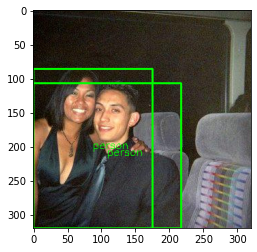

In [11]:
plot_img = plot_boxes(img, bboxes, names)
plot_image(plot_img)

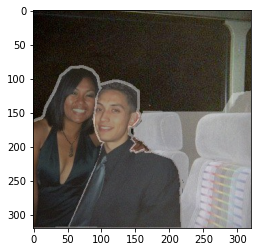

In [12]:
plot_img = plot_img_seg(img, seg_img, (seg_img > 0).astype(np.uint8))
plot_image(plot_img)

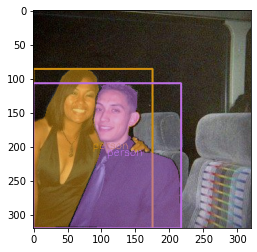

In [13]:
plot_img = plot_boxes_instance_masks(img, seg_img, bboxes, names, seg_ids)
plot_image(plot_img)

In [14]:
class ProposalLayer(nn.Module):
    def __init__(self, img_size, nms_thresh=0.7, n_train_pre_nms=2000, n_train_post_nms=1000,
                 n_test_pre_nms=600, n_test_post_nms=300, min_size=16):

        super().__init__()
        self.img_size = img_size
        self.nms_threshold = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def forward(self, locs, scores, anchors):
        if self.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        roi = loc2bbox(anchors, locs)
        roi = torch.clamp(roi, 0, self.img_size)

        # Remove predicted boxes with either height or width < threshold.
        widths = roi[:, 2] - roi[:, 0]
        heights = roi[:, 3] - roi[:, 1]
        keep = torch.where((heights >= self.min_size) & (widths >= self.min_size))[0]

        roi = roi[keep, :]
        scores = scores[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest and the the n_pre_nms highest.        
        indicies = torch.argsort(scores, descending=True)        
        indicies = indicies[:n_pre_nms]
        roi = roi[indicies, :]
        scores = scores[indicies]

        keep = nms(roi, scores, self.nms_threshold)
        keep = keep[:n_post_nms]
        roi = roi[keep]

        return roi

In [15]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, in_channels=256, mid_channels=256, ratios=[0.7, 1, 1.3],
                 anchor_scales=[4, 8, 16], sub_sample=16):
        super().__init__()

        # Note: all images in the forward pass need to be of shape 3 x img_size x img_size
        self.img_size = img_size
        self.anchors = generator_anchors(img_size // sub_sample, sub_sample, anchor_scales=anchor_scales, ratios=ratios)
        self.num_base_anchors = len(ratios) * len(anchor_scales)

        self.proposal_layer = ProposalLayer(img_size)

        self.conv = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.score = nn.Conv2d(mid_channels, 2 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)
        self.loc = nn.Conv2d(mid_channels, 4 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)

        normal_init(self.conv, 0.0, 0.01)
        normal_init(self.score, 0.0, 0.01)
        normal_init(self.loc, 0.0, 0.01)

    def forward(self, x):        
        n, _, height, width = x.shape        
        h = F.relu(self.conv(x))

        rpn_locs = self.loc(h)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)

        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()

        rpn_softmax_scores = F.softmax(rpn_scores.view(n, height, width, self.num_base_anchors, 2), dim=4)

        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = []
        roi_indices = []
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i], rpn_fg_scores[i], self.anchors)
            batch_index = i * torch.ones((len(roi),)).int()
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = torch.cat(rois, dim=0).to(device)
        roi_indices = torch.cat(roi_indices, dim=0).to(device)
        return rpn_locs, rpn_scores, rois, roi_indices

In [16]:
class BoxHead(nn.Module):
    def __init__(self, feature_dim, num_hidden, num_classes, p=0.1):
        super().__init__()

        self.linear = nn.Linear(feature_dim, num_hidden)
        self.cls_loc = nn.Linear(num_hidden, 4 * num_classes)
        self.score = nn.Linear(num_hidden, num_classes)
        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        h = F.relu(self.linear(x))
        h = self.dropout(h)
        roi_cls_locs = self.cls_loc(h)
        roi_scores = self.score(h)
        return roi_cls_locs, roi_scores


class BNLayer(nn.Module):
    def __init__(self, channels, conv_type=nn.Conv2d, kernel_size=3, stride=1, padding=1, **kwargs):
        super().__init__()

        self.conv = conv_type(channels, channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.act(x)


class SegHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layers = nn.Sequential(
            BNLayer(in_channels, kernel_size=1, padding=0),
            BNLayer(in_channels, conv_type=nn.ConvTranspose2d, stride=2, output_padding=1),
            BNLayer(in_channels),
            BNLayer(in_channels, conv_type=nn.ConvTranspose2d, stride=2, output_padding=1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3,
                                stride=1, padding=1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class RoIHead(nn.Module):
    def __init__(self, num_classes, output_size, num_hidden=256, in_channels=256, sub_sample=16, p=0.1):
        super().__init__()

        self.roi_pool = RoIPool(output_size, spatial_scale=1/sub_sample)
        
        self.box_head = BoxHead(output_size * output_size * in_channels, num_hidden, num_classes)
        self.seg_head = SegHead(in_channels, num_classes)

    def forward(self, x, rois, roi_indices):
        indicies_and_rois = torch.cat([
            roi_indices.float().unsqueeze(-1),
            rois
        ], dim=1)
        pool_vals = self.roi_pool(x, indicies_and_rois)

        pool_vals_fc = pool_vals.view(pool_vals.size(0), -1)
        roi_cls_locs, roi_scores = self.box_head(pool_vals_fc)
        
        seg_mask = self.seg_head(pool_vals)
        
        return roi_cls_locs, roi_scores, seg_mask

In [17]:
class MaskRCNN(nn.Module):
    def __init__(self, img_size, num_classes, output_size=7):
        super().__init__()
        
        self.img_size = img_size
        self.num_classes = num_classes
        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-3]
        self.backbone = nn.Sequential(*pretrained_model)
        self.region_proposal_network = RegionProposalNetwork(img_size, sub_sample=16)
        
        self.roi_head = RoIHead(num_classes, output_size)

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def forward_rpn(self, x):
        feature_map = self.backbone(x)
        rpn_locs, rpn_scores, rois, roi_indices = self.region_proposal_network(feature_map)
        return rpn_locs, rpn_scores, rois, roi_indices, feature_map

    def forward_roi(self, x, rois, roi_indices):
        roi_cls_locs, roi_scores, seg_mask = self.roi_head(x, rois, roi_indices)
        return roi_cls_locs, roi_scores, seg_mask

In [18]:
def loss(x, gt, c, rpn_locs, rpn_scores, rois, roi_indices, feature_map, roi_lambda=1.0):
    rpn_cls_loss, rpn_loc_loss = 0.0, 0.0
    roi_cls_loss, roi_loc_loss = 0.0, 0.0
    for i in range(len(x)):
        gt_i = gt[i].to(device)
        c_i = c[i].to(device)
        rois_i = rois[roi_indices == i]

        # RPN loss
        anchors = generator_anchors(img_size  // 16, sub_sample=16)
        anchor_labels, anchor_locations = create_anchor_labels(anchors, gt_i, img_size)

        rpn_cls_loss += F.cross_entropy(rpn_scores[i, :, :], anchor_labels, ignore_index = -1)

        temp_loss = F.smooth_l1_loss(anchor_locations, rpn_locs[i, :, :], reduction="none")
        label_filter = (anchor_labels > 0).float().unsqueeze(-1)
        temp_loss = temp_loss * label_filter
        rpn_loc_loss += torch.sum(temp_loss) / max(torch.sum(label_filter), 1)

        # ROI loss
        sample_roi, gt_roi_loc, gt_roi_label = create_box_target_labels(rois_i, gt_i, c_i)            

        sample_roi_index = torch.zeros(len(sample_roi)).to(device)
        roi_cls_loc, roi_score, seg_mask = model.forward_roi(
            feature_map[i, :, :, :].unsqueeze(0),
            sample_roi,
            sample_roi_index)
        
        roi_cls_loss += F.cross_entropy(roi_score, gt_roi_label)

        n_sample = roi_cls_loc.shape[0]
        roi_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]

        temp_roi_loss = F.smooth_l1_loss(roi_loc, gt_roi_loc, reduction="none")
        roi_label_filter = (gt_roi_label > 0).float().unsqueeze(-1)
        temp_roi_loss = temp_roi_loss * roi_label_filter            
        roi_loc_loss += torch.sum(temp_roi_loss) / max(torch.sum(roi_label_filter), 1)

    rpn_loss = rpn_cls_loss  + rpn_loc_loss
    roi_loss = roi_cls_loss + roi_lambda * roi_loc_loss

    return rpn_loss, roi_loss

In [19]:
model = MaskRCNN(img_size, num_classes)
model = model.to(device)

In [20]:
for idx, (imgs, seg_imgs, bboxes, class_idxs, seg_ids) in enumerate(train_loader):
    model.zero_grad()
    imgs = imgs.to(device)
    
    rpn_locs, rpn_scores, rois, roi_indices, feature_map = model.forward_rpn(imgs)
    batch_rpn_loss, batch_roi_loss = loss(imgs, bboxes, class_idxs, rpn_locs, rpn_scores, rois, roi_indices, feature_map)
    break